# **_Part-of Speech (POS) tagging as Sequence Labelling using RNNs_**

**Authors**: Giacomo Martelli, Marco Cucè, Riccardo De Matteo

In [7]:
# to print all output for a cell instead of only last one 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

### 1. Libraries

In [8]:
import os

import torch
import random
import numpy as np
import pandas as pd
import pickle 

import gensim
import gensim.downloader as gloader

import time 
from datetime import datetime

from collections import OrderedDict, namedtuple
from operator import itemgetter

from typing import Dict

# Fix data seed to achieve reproducible results
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

C:\Users\Riccardo\miniconda3\envs\nlp\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [9]:
print("Current work directory: {}".format(os.getcwd())) #print the current working directory 

data_folder = os.path.join(os.getcwd(),"data") # directory containing the notebook

if not os.path.exists(data_folder):   #create folder where all data will be stored 
    os.makedirs(data_folder)

Current work directory: c:\Users\Riccardo\Project\GitRepo\NLP-assignments\assignment1


### 2. Data preparation

Here we download the `dependency_treebank` dataset from the `NLTK` data module and we store it unzipped in the data folder.

In [ ]:
from urllib.request import urlopen
from io import BytesIO
from zipfile import ZipFile


def download_and_unzip_dataset():
    """
        Downloads and unzips the dataset for the assignment
    """
    dataset_folder = os.path.join(data_folder, "dependency_treebank")

    url = "https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/dependency_treebank.zip"

    if not os.path.exists(dataset_folder):
        print('downloading and extracting dataset to :',dataset_folder)
        with urlopen(url) as response:
            zipfile = ZipFile(BytesIO(response.read()))
            zipfile.extractall(path=data_folder)
    else :
        print("the dataset has been already downloaded")

download_and_unzip_dataset()

After downloading the dataset we encode it as a pandas dataframe and make some preprocessing, as follows:
- Remove of the third column because useless.
- Introduction of a boolean variable `to_lower`, which if set to `True` put all words to lower case. 
- Since each document can contain multiple sentences, we decided to split documents into sentences. Having to carry out a sequence labelling task, the grammatical analysis for tag assignment should take into account only single sentences, while there is no direct correlation between POS tags of words in different sentences.\
In addition, this will allow us to group sentences with similar length in batches, while documents are more variable in size, thus reducing the padding size.

After that a new pandas dataframe is created, where each row represents a sentence. The dataframe has the following columns:
- `split`: `train` if sentence belongs to a document of range 1-100, `val` if 101-150 and `test` if 151-199.
- `doc_id`: document's number containing that sequence.
- `sentence_num`: number to identify the sentence in the document.
- `words`: list of words inside the sentence.
- `tags`: list of tags relative to the words of the sentence.
- `num_tokens`: total number of words/tags inside the sentence (for testing purposes). 

Finally, we return the newly generated pandas dataframe `df_final` and the list of unique tags `unique_tags` and unique words `unique_words` in the entire dataset.


In [ ]:
#encode dataset in pandas dataframe 

def encode_dataset(dataset_name: str, to_lower: bool) -> pd.DataFrame:
  """
    Takes the dataset and encodes it in a pandas dataframe having six columns ['split', 'doc_id', 'sentence_num', 'words', 'tags', 'num_tokens']. Computes also unique tags set and unique words set and returns them with the dataframe.
  
  """
  print("Encoding dataset as pandas dataframe...")

  dataset_folder = os.path.join(data_folder,"dependency_treebank")
  
  dataframe_rows = []             #dataframe that will contain all the sentences in all the documents, each sentence as a list of word and a list of corresponding tags
  unique_tags = set()             
  unique_words = set()

  for doc in os.listdir(dataset_folder):
    doc_num = int(doc[5:8])
    doc_path = os.path.join(dataset_folder,doc)

    with open(doc_path, mode='r', encoding='utf-8') as file:
      df = pd.read_csv(file,sep='\t',header=None,skip_blank_lines=False)
      df.rename(columns={0:'word',1:"TAG",2:"remove"},inplace=True)
      df.drop("remove",axis=1,inplace=True)

      if to_lower: df['word'] = df["word"].str.lower() #set all words to lower case
      
      #create another column that indicate the group id by sentence 
      df["group_num"] = df.isnull().all(axis=1).cumsum()
      df.dropna(inplace=True)
      df.reset_index(drop=True, inplace=True)
      
      unique_tags.update(df['TAG'].unique())     #save all the unique tags in a set 
      unique_words.update(df['word'].unique())   #save all the unique words in a set 

      #generate sentence list in a document 
      df_list = [df.iloc[rows] for _, rows in df.groupby('group_num').groups.items()]
      for n,d in enumerate(df_list) :           #for each sentence create a row in the final dataframe
          dataframe_row = {
              "split" : 'train' if doc_num<=100 else ('val' if doc_num<=150  else 'test'),
              "doc_id" : doc_num,
              "sentence_num" : n,
              "words": d['word'].tolist(),
              "tags":  d['TAG'].tolist(),
              "num_tokens": len(d['word'])
          }
          dataframe_rows.append(dataframe_row)

  dataframe_path = os.path.join(data_folder, dataset_name)
  df_final = pd.DataFrame(dataframe_rows)
  df_final.to_csv(dataframe_path + ".csv")                      #save as csv to inspect

  print("Encoding completed!")
    
  return  df_final, unique_tags, unique_words

df, unique_tags, unique_words = encode_dataset("dataset", to_lower = False)

print('Some words from the dataset:', random.choices(list(unique_words),k=15))
print('Some tags from the dataset:', random.choices(list(unique_tags),k=15))

print('\nencoded dataframe:')
df.head(10)

  

Next we have to build the dictionaries that will be used for the generation of the embedding matrix and one hot encoding (done by the loss function) of the tags.
\
\
The function `build_dict` takes the list of words and tags of the dataframe, and returns:
- `word2int`: dictionary which associates each word with an integer.
- `int2word`: dictionary which associates each integer with the relative word.
- `tag2int`: dictionary which associates each tag with an integer.
- `int2tag`: dictionary which associates each integer with the relative tag.

In addition, we save these four dictionaries in the `dictionaries.pkl` file to load them if already available and make the process faster.

In [ ]:
dict_path = os.path.join(data_folder,'dictionaries.pkl') #path where dictionaries will be saved 

def build_dict(words : list[str], tags : list[str]): 
    """
        Builds 4 dictionaries word2int, int2word, tag2int, int2tag and returns them
    """
    
    word2int = OrderedDict()
    int2word = OrderedDict()

    for i, word in enumerate(words):
        word2int[word] = i+1           #plus 1 since the 0 will be used as tag token 
        int2word[i+1] = word

    tag2int = OrderedDict()
    int2tag = OrderedDict()

    for i, tag in enumerate(tags):
        tag2int[tag] = i+1
        int2tag[i+1] = tag
    
    print('saving dictionaries as pickle files')
    pickle_files = [word2int,int2word,tag2int,int2tag]
    
    with open(dict_path, 'wb') as f:
        pickle.dump(pickle_files, f)

    return word2int,int2word,tag2int,int2tag

word2int,int2word,tag2int,int2tag = build_dict(unique_words,unique_tags)

Once the dictionaries have been built, we use them in the function `build_tokenized_dataframe` which tokenizes each word and tag of the dataframe by substituting to them the correspondent index found in the dictionary. Then we add a new column called `split`, which identifies if a sentence belongs to the train, validation or test part, and another one called `num_tokens` storing the number of words in that sentence.
\
\
The function `check_dataframe_tokenization` is used in order to verify if the words and tags of the original dataset have been tokenized correctly. In particular, it makes a comparison between the original words of the dependency treebank dataset and the ones of the new tokenized dataframe. Then, if everything is OK, we save the dataframe as a pickle file called `token_dataset.pkl`, again to load it afterwards, if already available.

In [ ]:
token_df_path = os.path.join(data_folder, "token_dataset.pkl") #tokenized dataframe path

def build_tokenized_dataframe(word2int: Dict, tag2int: Dict, df: pd.DataFrame):
    """
        Given the dictionaries word2int, tag2int and the dataframe, creates a dataframe were every word and tag is represented by its token and returns it
    """
    print('Initiating tokenization of words and tags in dataframe')
    tokenized_rows = []
    for words,tags in zip(df['words'],df['tags']):
        tokenized_row = {'words_token':[word2int[word] for word in words ],'tags_token':[tag2int[tag] for tag in tags ]}
        tokenized_rows.append(tokenized_row)
    
    tokenized_df = pd.DataFrame(tokenized_rows)

    tokenized_df.insert(0,'split',df['split'])
    tokenized_df.insert(1,'num_tokens',df['num_tokens'])

    print('Tokenization completed')

    return tokenized_df


def check_dataframe_tokenization(tokenized_df, normal_df, int2word, int2tag) :
    """
       Checks if the tokenized dataframe will lead to the normal dataframe usind the dictionaries int2word and int2tag
    """
    for n, (w_t, t_t) in enumerate(zip(tokenized_df['words_token'],tokenized_df['tags_token'])):
        if not normal_df.loc[n,'words'] == [int2word[word_token] for word_token in w_t]:
            print('words tokenization gone wrong') 
            return False
        if not normal_df.loc[n,'tags'] == [int2tag[tag_token] for tag_token in t_t]:
            print('tags tokenization gone wrong')
            return False 
    
    print('\nAll right with dataset tokenization')
    print('Saving tokenized dataframe')
    
    tokenized_df.to_pickle(token_df_path)


tokenized_df = build_tokenized_dataframe(word2int,tag2int,df)
check_dataframe_tokenization(tokenized_df,df, int2word, int2tag)


Now, let's have a look at the tokenized dataframe 

In [ ]:
tokenized_df.head()

### 3. GloVe embeddings

In the next section we will download the GloVe embeddings which will then be used to construct the embedding matrix.

In [ ]:
glove_path = os.path.join(data_folder, "token_dataset.pkl") #tokenized dataframe path

def download_glove_emb():   
    """
        Download the glove embedding and returns it 
    """
    print('downloading glove embeddings ')        
    embedding_dimension=300
    download_path = "glove-wiki-gigaword-{}".format(embedding_dimension)
    emb_model = gloader.load(download_path)
    
    return emb_model

glove_embeddings = download_glove_emb()

Now that we have the glove embeddings, we can check if there are some Out Of Vocabulary (OOV) words.
\
\
A word is considered OOV if it is present in our dataset but not in the GloVe embeddings. Therefore, we take each word from the `unique_words` list of the dataframe and look if it is present inside GloVe, otherwise we add it to a list called `oov_words`.
\
\
Next, the function prints as output the number of unique words in the dataframe, the percentage of OOV terms with respect to the total number of words, and an example of some words not present in the dataframe.

In [ ]:
def check_OOV_terms(embedding_model: gensim.models.keyedvectors.KeyedVectors, unique_words: list[str], lower: bool):
    """
        Given the embedding model and the unique words in the dataframe computes and prints the out-of-vocabulary words 
    """
    oov_words = []

    if lower:
        words = set([x.lower() for x in unique_words])
    else: 
        words = unique_words

    for word in words:
        try: 
           embedding_model[word]
        except:
           oov_words.append(word) 
    
    print("Total number of unique words in dataset:",len(words))
    print("Total OOV terms: {0} ({1:.2f}%)".format(len(oov_words), (float(len(oov_words)) / len(words))*100))
    print("Some OOV terms:",random.sample(oov_words,15))

check_OOV_terms(glove_embeddings, unique_words,False)


The `dependency_treebank` dataset contains a total number of 11968 unique words. By using the GloVe embeddings for our embedding matrix, we obtain 3745 OOV words, that is the 31.29% of all words in our dataset which is surprisingly high.

Here is a random example of these words:\
`['Darrell', 'Series', 'Merc', 'Economic', 'Officials', 'Jaguar', 'Environment', 'twin-jet']`\
It is clear how many of them begin with a capital letter.

For this reason we have introduced the possibility to put every word in the dataset to lowercase, as discussed previously.
Once all words have been reduced to lower case, the OOV words within the dataframe become 676, the 6.18% of all words; much less than before.

We tested both configurations but we didn't observe any improvement with having less OOV, so we have decided to set `to_lower = False`. This decision was taken because, having to assign a tag to each word within a sentence, the presence of capital letters could actually help the network in correctly labeling that word.

### 4. Embedding matrix

We can finally build our embedding matrix by passing to the function `build_embedding_matrix` the GloVe embeddings and the `word2int` dictionary, thus:
- If a dataframe's word (identified by its relative integer) is already present as GloVe embedding we store it as it is in the embedding matrix.
- Otherwise we assign as embedding at the index of the corresponding OOV word, a random vector of size 300 (= GloVe embedding dimension) from a uniform distribution.

In [ ]:
# This function is used to inspect values inside the glove embeddings. Return the max and min value inside vectors 
def check_value_distribution_glove(glove: gensim.models.keyedvectors.KeyedVectors):
    """
        Computes maximum and minimum values of GloVe embedding and prints them
    """
    max_v = np.max([(np.max(glove[i])) for i in range(len(glove))])
    min_v = np.min([(np.min(glove[i])) for i in range(len(glove))])

    print('Max value inside glove embeddings:',max_v)
    print('Min value inside glove embeddings:',min_v)


def build_embedding_matrix(emb_model: gensim.models.keyedvectors.KeyedVectors, word2int: Dict[str, int]) -> np.ndarray:
    """
        Given the embedding model and the dict. word2int. If there is the embedding for the word, we add it to the embedding_matrix. In negative case we put a list of random values.
        Return the embedding matrix
    """
    check_value_distribution_glove(emb_model)
   
    embedding_dimension = len(emb_model[0]) #how many numbers each emb vector is composed of                                                           
    embedding_matrix = np.zeros((len(word2int)+1, embedding_dimension), dtype=np.float32)   #create a matrix initialized with all zeros 

    for word, idx in word2int.items():
        try:
            embedding_vector = emb_model[word]
        except (KeyError, TypeError):
            embedding_vector = np.random.uniform(low=-0.05, high=0.05, size=embedding_dimension)

        embedding_matrix[idx] = embedding_vector     #assign the retrived or the generated vector to the corresponding index 
    
    print('Saving embedding matrix')
    path = os.path.join(data_folder, "emb_matrix")
    np.save(path,embedding_matrix,allow_pickle=True)

    print("Embedding matrix shape: {}".format(embedding_matrix.shape))

    return embedding_matrix

embedding_matrix = build_embedding_matrix(glove_embeddings, word2int)

Again, let's have a look at the first few rows of the freshly created embedding matrix, to get a sense of it. As we can see the very first row is full of zeros since it is the 'fake embedding' of the padding token which will never be used in practice.

In [ ]:
pd.DataFrame(embedding_matrix).head()

To be completely sure that the embedding matrix has been built correctly, we check that the embedding vector associated with an index in the embedding matrix is the same as the one retrieved from glove by passing to it the word to which that index correspond. 

In [ ]:
def check_id_corr(int2word : Dict[int,str],glove: gensim.models.keyedvectors.KeyedVectors, matrix, dataframe ):
    """
        Checks whether the tokenized dataframe and the index of the embedding matrix correspond
    """
    oov_words_ = []

    for token_sentence in dataframe['words_token']:

        for token in token_sentence:
            emb1 = matrix[token]
            word = int2word[token]
            emb2 = None
            try:
                emb2 = glove[word]
            except:
                oov_words_.append(word)
            if emb2 is not None:
                assert(np.array_equal(emb1,emb2))

    print('Double check OOV number:',len(set(oov_words_)))

check_id_corr(int2word,glove_embeddings,embedding_matrix,tokenized_df)

Since no error has been thrown, we can safely proceed with the next steps.

### 5. Data loading

This can be the first run or not. Do not run the above cells if this is not the first time you do it, in order to avoid downloading the GloVe embeddings more than once (the process is really slow).\
Whatever the case, now the folder `data` exists, so we call `load_data` in order to load all the data that we need to perform the next steps.

In practice we need:
- `emb_matrix`: the embedding matrix.
- `token_dataset`: the dataset tokenized with the integers in place of words and tags.
- `word2int`: dictionary associating each word with its integer.
- `int2word`: reverse of `word2int`.
- `tag2int`: dictionary associating each tag with its integer.
- `int2tag`: reverse of `tag2int`.

In [10]:
def load_data():
    """
        Loads the data "emb_matrix, token_dataset, word2int, int2word, tag2int, int2tag " and returns them
    """
    emb_matrix_path = os.path.join(data_folder,'emb_matrix.npy')
    token_dataset_path = os.path.join(data_folder,'token_dataset.pkl')
    dictionaries_path = os.path.join(data_folder,'dictionaries.pkl')

    if os.path.exists(emb_matrix_path) and os.path.exists(token_dataset_path):
        print('Loading embedding matrix')
        emb_matrix = np.load(emb_matrix_path,allow_pickle=True)
        print('Loading tokenized dataset')
        token_dataset = pd.read_pickle(token_dataset_path)
        print('Loading dictionaries')
        with open(dictionaries_path, 'rb') as f:
            word2int,int2word,tag2int,int2tag = pickle.load(f)
        
        print('All data loaded')
    else:
        print('What you are looking for is not present in the folder')
        emb_matrix, token_dataset = None, None

    return emb_matrix, token_dataset, word2int, int2word, tag2int, int2tag

emb_matrix, token_dataset, word2int, int2word, tag2int, int2tag = load_data()

Loading embedding matrix
Loading tokenized dataset
Loading dictionaries
All data loaded


Before we can start we also need to import all the libraries which we will use for the POS tagging task.\
In particular:
- We have decided to use `pytorch` as deep learning framework.
- The results of the train, val and test loop have been plotted using the `tensorboard` platform.
- In order to analyze the errors and reason on improvements, we took advantage of the `sklearn` tools. 

In [11]:
#pytoch imports

import torch.nn as nn
import torch.optim as optim
import torch.nn.utils.rnn as rnn
from torch.utils.data import Dataset

from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torchtext.legacy.data import BucketIterator

from torch.utils.tensorboard import SummaryWriter

#scikit-learn imports 

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sn
import matplotlib.pyplot as plt

### 6. Data Loaders

In order generate mini-batches to be passed to the network for each split we leveraged a `torchtext` utility, such as `BucketIterator`. It ensures that each mini-batch is composed of sequences of nearly the same length (depending on the chosen batch size), in order to add the minimum padding possible to each Tensor.\
In order to do so, we needed to create a Pytorch Dataset since this is what is requested by the BucketIterator.

Thus:
- `DataframeDataset`: transforms the tokenized dataframe into a dataset, because `BucketIterator` needs in input a `Dataset` type.
- `create_dataloaders`: divides the tokenized dataframe for training, validation and test. A `DataframeDataset` for each split is created and passed to `BucketIterator` which returns the dataloaders.
- `check_data_loaders`: counts the maximum difference in length between the sentences of each mini-batch and prints random examples to understand if everything is working fine.

In [12]:
class DataframeDataset(Dataset):

    def __init__(self, dataframe: pd.DataFrame):
        self.X = dataframe['words_token']      #select only the column of tokenized words 
        self.y = dataframe['tags_token']       #select only the column of tokenized tags 
       
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        return {'words': self.X[idx],'tags': self.y[idx]}

def create_dataloaders(b_s : int):     #b_s = batch_size
    
    train_df = token_dataset[token_dataset['split'] == 'train'].reset_index(drop=True)      
    val_df = token_dataset[token_dataset['split'] == 'val'].reset_index(drop=True)
    test_df = token_dataset[token_dataset['split'] == 'test'].reset_index(drop=True)

    #create DataframeDataset objects for each split 
    train_dataset = DataframeDataset(train_df)
    val_dataset = DataframeDataset(val_df)
    test_dataset = DataframeDataset(test_df)


    # Group similar length text sequences together in batches and return an iterator for each split.
    train_dataloader,val_dataloader,test_dataloader = BucketIterator.splits((train_dataset,val_dataset,test_dataset),
                                                        batch_sizes=(b_s,b_s,b_s), sort_key=lambda x: len(x['words']), 
                                                        repeat=True, sort=False, shuffle=True, sort_within_batch=True)
    
    return train_dataloader,val_dataloader,test_dataloader 

#this function is used to inspect the iterators. 
def check_data_loaders(train_dataloader,val_dataloader,test_dataloader):

    for n,dataloader in enumerate((train_dataloader,val_dataloader,test_dataloader)):

        dataloader.create_batches() # Create batches - needs to be called before each loop.

        diff_list = []
        for batch in dataloader.batches:

            min = np.min([len(example['words']) for example in batch])     #minimum lenght of a Tensor (sentence) in a batch 
            max = np.max([len(example['words']) for example in batch])     #maximum lenght of a Tensor (sentence) in a batch 

            diff = max - min   #biggest difference

            diff_list.append(diff)
        
        diff_list.sort(reverse=True)
        
        s = 'train' if n==0 else ('val' if n==1 else 'test')
        print('In',s+'_dataloader the list of maximum differences between sentences for each batch is: \n',diff_list)
        print('In',s+'_dataloader the two biggest difference in number of tokens between two sentences in the same batch is:', diff_list[0],',', diff_list[1])

    print('\n')

    #print random sentence from train_dataloader
    from operator import itemgetter
    train_dataloader.create_batches()
    for batch in train_dataloader.batches:
        for example in batch:
            print('random sentence from train_dataloader:')
            print(itemgetter(*example['words'])(int2word))
            print(itemgetter(*example['tags'])(int2tag))
            break
        break

In [13]:
tr, vl, ts = create_dataloaders(16)
check_data_loaders(tr,vl,ts)

In train_dataloader the list of maximum differences between sentences for each batch is: 
 [203, 56, 7, 6, 6, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
In train_dataloader the two biggest difference in number of tokens between two sentences in the same batch is: 203 , 56
In val_dataloader the list of maximum differences between sentences for each batch is: 
 [21, 6, 3, 3, 3, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
In val_dataloader the two biggest difference in number of tokens between two se

As we can see, the maximum length distance between two sentences in each batch is very little on average (depending on the chosen batch size) and for many batches even zero.\
We still observe a batch with a large maximum difference betweeen two sentences that belongs to it. \
This huge difference is given by a single very long sentence within a document of the train set. We tried to remove it and compare the performances but we didn't notice any improvement, so we decided to leave the dataframe unchanged.

### 7. Model definition

It's now time to build our custom model. We defined a modular class which, depending on the passed parameters, allows us to perform experiments with different architectures.

- `self.embedding`: embedding layer, constructed by passing to `create_emb_layer` the pretrained embedding matrix. This layer is not trainable. 
- `self.rnn`: RNN layer (by changing the value of `use_GRU`, the LSTM or the GRU is used).
- `self.middle_dense`: default value set to `None`, meaning that the model will have only one dense layer. To add another one, the boolean `double_dense` must be set to `True`.
- `self.hidden2tag`: last (and perhaps only) dense layer of the network. Takes in input a vector for each word in a sentence and returns for each of them a vector whose length is the number of the token that we want to predict. 

In [14]:
def create_emb_layer(weights_matrix: np.ndarray, pad_idx : int):
    """
        creates adn returns the embedding layer
    """
    matrix = torch.Tensor(weights_matrix)   #the embedding matrix 
    _ , embedding_dim = matrix.shape 
    emb_layer = nn.Embedding.from_pretrained(matrix, freeze=True, padding_idx = pad_idx)   #load pretrained weights in the layer and make it non-trainable 
    
    return emb_layer, embedding_dim

class custom_model(nn.Module):
    """
        Class defining our models 
    """
    def __init__(self, emb_matrix : np.ndarray, hidden_dim: int, tag_output_dim: int, pad_idx: int, double_lstm : bool, double_dense : bool, use_GRU: bool) :
        super().__init__()

        #define the name of the specific architecture 
        if double_lstm + double_dense + use_GRU == 0: 
            self.name = 'naive'
        else :
            self.name = 'double_lstm' if double_lstm else ('double_dense' if double_dense else 'use_GRU') 

        self.embedding, embedding_dim = create_emb_layer(emb_matrix,pad_idx)   #instantiate the embedding layer 

        if use_GRU:
            self.rnn = nn.GRU(embedding_dim, hidden_dim, batch_first = True, num_layers = int(double_lstm)+1, bidirectional = True)
        else :
            self.rnn = nn.LSTM(embedding_dim, hidden_dim, batch_first = True, num_layers = int(double_lstm)+1, bidirectional = True)

        self.middle_dense = None    #an optional layer that lays between the rnn layer and the last dense one

        if double_dense:
            self.middle_dense = nn.Linear(hidden_dim*2,hidden_dim)
            self.hidden2tag = nn.Linear(hidden_dim, tag_output_dim)
        else :
            self.hidden2tag = nn.Linear(hidden_dim * 2 , tag_output_dim)


    def forward(self, sentences, sentences_lengths):
        
        embeds = self.embedding(sentences)
        packed_embeds = pack_padded_sequence(embeds, sentences_lengths, batch_first=True, enforce_sorted=False)   #pack the sentences batch so that no unnecessary computation is performed for padding tokens

        packed_out, _  = self.rnn(packed_embeds)
        out, _ = pad_packed_sequence(packed_out, batch_first=True)     #pad the sequence back since it has to be passed to the dense layer 

        if self.middle_dense is not None :
            out = self.middle_dense(out)

        tag_space = self.hidden2tag(out)
        
        return tag_space

In the next cell we define some 'helper' functions that will be used in the train and test pipeline. Those simple functions are: 
- `init_weights`: initialize the weights and biases of the LSTM, Fully Connected and GRU (if `use_GRU = True`) layers, by enforcing mean = 0 and standard deviation = 0.1.
- `compute_class_weights`: computes weights to be used in the loss function to counteract imbalanced data. In particular, more weight will be given to the loss when the model predict wrongly a tag associated to words which are very few in the train dataset.
- `get_to_be_masked_tags`: returns a `torch.Tensor` which contains the indexes of the punctuation's and symbols' tags to ignore them in the evaluation of the model.
- `reshape_and_mask`: reshapes the tensors of the predicted and true labels (in order to be compliant with `nn.crossEntropyLoss`) and mask out the punctuation indexes.
- `acc_and_f1`: compute accuracy and f1 score based on list of true and predicted labels.

In [15]:
def init_weights(m):
    """
        Initiliaze weights of LSTM, GRU & FC
    """
    for _, param in m.named_parameters():
        if isinstance(m, nn.LSTM) or isinstance(m, nn.Linear) or isinstance(m, nn.GRU):
            nn.init.normal_(param.data, mean = 0, std = 0.1)   #initialize weights with normal distribution

def compute_class_weights():
    """
        Compute weights to be passed to loss function to counteract imbalanced data 
    """
    y = token_dataset[token_dataset['split']=='train']['tags_token'].explode().to_numpy()   #put all the tags in the train dataset in a list 
    classes = np.unique(y)   #create a list of only unique tags 

    w = np.concatenate(([0],compute_class_weight('balanced',classes=classes,y=y)))    #use compute_class_weigth method from scikit-learn and add the 0 weight for the padding token 
    
    return torch.Tensor(w)


def get_to_be_masked_tags():
    """
        Return a torch tensor which contains the indexes of the tags that we don't want to evaluate (punctuation)
    """
    punctuation_tags = ['$', '``', '.', ',', '#', 'SYM', ':', "''",'-RRB-','-LRB-']   #tags to be masked 
    token_punctuations = [tag2int[tag] for tag in punctuation_tags]  #indexes of tags to be masked 

    print('the indexes of punct tags:',token_punctuations) # int of punctuation's tokens
    print([int2tag[token_int] for token_int in token_punctuations]) 

    return torch.LongTensor(token_punctuations+[0]) #0 is the pad token 

to_mask = get_to_be_masked_tags()


def reshape_and_mask(predictions: torch.Tensor, targets: torch.LongTensor):
    """
        Return two tensors : the predicted labels and the true labels, both after removing unwanted classes and reshaped to be compliant with crossEntropyLoss
    """
    max_preds = predictions.argmax(dim=1)   #get the index of maximum value of n-dim vector (n is the number of possible tags) to retrive model prediction 
    non_masked_elements = torch.isin(targets, to_mask, invert=True)   #create a boolean mask removing unwanted tags 
    
    return max_preds[non_masked_elements],targets[non_masked_elements]    #return tensors masked 


def acc_and_f1(y_pred: torch.LongTensor, y_true: torch.LongTensor):
    """
        Return accuracy and f1-score of every example (word) in an epoch 
    """
    correct = y_pred.eq(y_true)          
    acc = correct.sum()/y_true.shape[0] 

    f1 = f1_score(y_true,y_pred,average='macro')

    return acc,f1

the indexes of punct tags: [11, 40, 32, 8, 20, 13, 29, 31, 34, 28]
['$', '``', '.', ',', '#', 'SYM', ':', "''", '-RRB-', '-LRB-']


Here we can see the tags that we don't want to take into account for model evaluation scores, along with their corresponding indexes. 

### 8. Train and Validation

In this section, we finally define the pipelines used to train and evaluate our models. They will be used in the subsequent cells in order to evaluate different architectures while keeping the hyperparameters fixed.

In [17]:
def train_loop(model: nn.Module, iterator : BucketIterator, optimizer: optim.Optimizer, criterion, pad_idx : int):
    """ Args:
         - model: the sequence pos tagger model istantiated with fixed hyperparameters.
         - iterator: dataloader for passing data to the network in batches 
         - optimizer: gradient descent optimizer for backward pass 
         - criterion: loss function 
         - pad_idx: index of the padding token 
        
        Return:
         - epoch_loss: the average loss computed as mean of the loss for each minibatch.
         - epoch accuracy: accuracy for an epoch that doesn't take into account the punctuation marks and symbols.
         - epoch_f1: f1 score for an epoch that doesn't take into account the punctuation marks and symbols.    
    """

    batch_loss = 0
    
    tot_pred , tot_targ = torch.LongTensor(), torch.LongTensor()

    model.train()
    
    iterator.create_batches()    #generate batches from dataloader 

    for batch_id, batch in enumerate(iterator.batches):

        batch_X = [torch.LongTensor(example['words']) for example in batch]    #list of tensors of words token for each sentence in a batch 
        batch_y = [torch.LongTensor(example['tags']) for example in batch]     #list of tensors of tags token for each sentence in a batch 

        batch_X_lenghts = [len(example['words']) for example in batch]         #lenght of each sentence before padding 

        #pad the sentences to create a fixed size batch 
        padded_X = rnn.pad_sequence(batch_X, batch_first = True, padding_value = pad_idx)
        padded_y = rnn.pad_sequence(batch_y, batch_first = True, padding_value = pad_idx)

        #zero the gradients 
        model.zero_grad(set_to_none=True)
        optimizer.zero_grad()            

        predictions = model(padded_X, batch_X_lenghts)   #compute predictions 

        #reshape all predictions and targets for a batch 
        predictions = predictions.view(-1,predictions.shape[-1])    
        targets = padded_y.view(-1)

        loss = criterion(predictions, targets)         #compute the loss 

        pred, targ = reshape_and_mask(predictions,targets)
        tot_pred = torch.cat((tot_pred,pred))          #concatenate the new tensors with the one computed in previous steps
        tot_targ = torch.cat((tot_targ,targ))

        #backward pass 
        loss.backward()
        optimizer.step()

        batch_loss += loss.item()
        

    epoch_loss = batch_loss/(batch_id+1)
    epoch_acc, epoch_f1 = acc_and_f1(tot_pred,tot_targ)

    return epoch_loss,epoch_acc,epoch_f1


def eval_loop(model: nn.Module, iterator: BucketIterator, criterion, pad_idx: int):
    """ Args:
         - model: the sequence pos tagger model istantiated with fixed hyperparameters.
         - iterator: dataloader for passing data to the network in batches 
         - criterion: loss function 
         - pad_idx: index of the padding token 
        
        Return:
         - epoch_loss: the average loss computed as mean of the loss for each minibatch.
         - epoch accuracy: accuracy for an epoch that doesn't take into account the punctuation marks and symbols.
         - epoch_f1: f1 score for an epoch that doesn't take into account the punctuation marks and symbols.
         - tot_pred: tensor containing the predicted labels (tag in numeric format) associated to each word received as input.
         - tot_labels: tensor containing in order the true labels (tag in numeric format) associated to each word received as input.  
    """
     
    batch_loss = 0
    
    tot_pred , tot_targ = torch.LongTensor(), torch.LongTensor()
    
    model.eval()   #model in eval mode 
    
    iterator.create_batches()

    with torch.no_grad(): #without computing gradients since it is evaluation loop
    
        for batch_id, batch in enumerate(iterator.batches):

            batch_X = [torch.LongTensor(example['words']) for example in batch]
            batch_y = [torch.LongTensor(example['tags']) for example in batch]

            batch_X_lenghts = [len(example['words']) for example in batch]

            padded_X = rnn.pad_sequence(batch_X, batch_first = True, padding_value = pad_idx)
            padded_y = rnn.pad_sequence(batch_y, batch_first = True, padding_value = pad_idx)
            
            predictions = model(padded_X,batch_X_lenghts)
            
            predictions = predictions.view(-1, predictions.shape[-1])
            targets = padded_y.view(-1)
            
            loss = criterion(predictions, targets)
            
            pred, targ = reshape_and_mask(predictions,targets)
            tot_pred = torch.cat((tot_pred,pred))
            tot_targ = torch.cat((tot_targ,targ))

            batch_loss += loss.item()
            

    epoch_loss = batch_loss/(batch_id+1)
    epoch_acc, epoch_f1 = acc_and_f1(tot_pred,tot_targ)

    return epoch_loss,epoch_acc,epoch_f1,tot_pred,tot_targ

Now that we have the train and eval loop we can combine them. Those two phases will be alternated for each epoch in order to see the progresses made by our model.\
Here we also instantiate the optimizer, the loss criterion and the model itself with the parameters that we specify.\
The `train_and_eval` function takes as parameter the `Architectures` list which contains the different model architectures that we want to try and that will be trained and evaluated in turn over the entire dataset.\
A dictionary `models_info` containing the results for each of these architectures is then returned. For each architecture it contains:
- best_f1: the best f1 score reached at some point by the model. 
- val_loss
- val_acc
- val_f1 
- tot_pred: a list containing all the tag label predicted by the network for each word.
- tot_targ: a list containing all the true tag label that should have been predicted for each word. 
- model: the entire model. This wil be useful when we will evaluate the best one on the train set. 

In [30]:
def train_and_eval(architectures, param, train_dataloader,eval_dataloader):
    """
        Runs the train and eval loop and keeps track of all the information of the model [best f1 score, predicted tags, corresponding tags, model, epoch]. Returns those infos
    """
    models_info = {}

    criterion = nn.CrossEntropyLoss(ignore_index = param['pad_idx'], weight = compute_class_weights() if param['use_class_weights'] else None)  #instantiate the loss function possibly with weight 

    for architecture in architectures:     #for each specified architecture do : 

        #unpack parameters for model creation 
        double_lstm, double_dense, use_gru = architecture.double_lstm, architecture.double_dense, architecture.use_gru

        model = custom_model(emb_matrix,param['hidden_state'],param['output_dim'],param['pad_idx'],double_lstm,double_dense,use_gru)      #build model 

        if param['use_init_weights'] :  model.apply(init_weights)           #weight inizialization 

        #init optimizer 
        if param['optimizer'] == 'Adam': 
            optimizer = optim.Adam(model.parameters()) 
        elif param['optimizer'] == 'SGD': 
            optimizer = optim.SGD(model.parameters(),lr=param['lr'])
        else : 
            raise Exception('optimizer must be either SGD or Adam')
        
        models_info[model.name] = {'best_f1':-1, 'val_loss': [], 'val_acc': [], 'val_f1': []}

        print('\ntrain and eval loops for architecture:',model.name)

        for epoch in range(param['n_epochs']): #epoch loop

            start_time = time.time()
            
            train_epoch_loss, train_epoch_acc, train_epoch_f1 = train_loop(model, train_dataloader, optimizer, criterion, param['pad_idx']) #train
            eval_epoch_loss, eval_epoch_acc, eval_epoch_f1, tot_pred, tot_targ = eval_loop(model, eval_dataloader, criterion, param['pad_idx']) #eval
            
            end_time = time.time()

            tot_epoch_time = end_time-start_time          
            
            if eval_epoch_f1 > models_info[model.name]['best_f1']: #updates infos if current f1 is better then the previous one 

                models_info[model.name]['best_f1'] = eval_epoch_f1
                models_info[model.name]['tot_pred'], models_info[model.name]['tot_targ'] =  tot_pred, tot_targ
                models_info[model.name]['model'] = model 
                models_info[model.name]['epoch'] = epoch+1
    

            #log accuracy data on tensorboard  
            models_info[model.name]['val_loss'].append(eval_epoch_loss)
            models_info[model.name]['val_acc'].append(eval_epoch_acc)
            models_info[model.name]['val_f1'].append(eval_epoch_f1)

            print(f'Epoch: {epoch+1:02} | Epoch Time: {tot_epoch_time:.4f}')
            print(f'\tTrain Loss: {train_epoch_loss:.3f} | Train Acc: {train_epoch_acc*100:.2f}% | Train F1: {train_epoch_f1:.2f}')
            print(f'\t Val. Loss: {eval_epoch_loss:.3f} | Eval. Acc: {eval_epoch_acc*100:.2f}% | Eval. F1: {eval_epoch_f1:.2f}')
    
    return models_info

Accoring to our experimental results obtained after an hyperparameter tuning phase, here are the ones that we are using to train each architecture:
- `BATCH_SIZE = 16`: we have experimented with the sizes a little bit, but we don't want batches to be neither too small, to avoid noise in the gradients, nor too big, to speed up the process. Since we didn't see big differences for a batch size range between 8 and 32, we decided to set `BATCH_SIZE = 16`.
- `LR = 0.4`: we obtained the best results using `Adam`, which automatically sets the initial learning rate. To instead use `SGD`, we found `LR = 0.4` to be quite good.
- `HIDDEN_STATE = 128`: it is well known that setting an high dimension of the hidden layers would ensure to the networks the ability to represents better the informations between the states, with respect to a small hidden dimension. For this reason we tried three different dimensions: 64, 128 and 256. The results of the comparison are quite similar but confirm the assumption, and we see that an `HIDDEN_STATE = 128` well represents the data.
- `N_EPOCHS = 15`: with a small enough batch size, `N_EPOCHS = 15` seems enough to obtain good results and avoid overfitting.
- `USE_INIT_WEIGHTS = False`: as already described, we have inserted a weight initialization for the LSTM and FC layers. Unfortunately it seems that initializing the weights with `mean = 0` and `std = 0.1` doesn't actually help the convergence of the gradient. On the contrary, by setting `USE_INIT_WEIGHTS = False` allows to obtain an increase on the F1 score of 1-2% points.
- `USE_CLASS_WEIGHTS = False`: if set to `True` the model would call the function `compute_class_weights` which we have defined in order use a weighted loss. Nevertheless, to train our model we decided to set it to `False`, the reasons will be explained in the error analysis section.
- `OPTIMIZER = 'Adam'`: we have tried many different types of gradient descent optimizers, such as: `SGD`, `SGD` with `momentum`, `RMS-prop` and `Adam`. For this particular task, `Adam` seems to be the best choice, althought choosing the best configurations of hyperparameters for `SGD` with `momentum` could achieve comparable performances.

In [31]:
#PARAMETERS, HYPERPARAMETERS AND USEFUL OBJECTS 

#param
PAD_IDX = 0                     # pad index
OUTPUT_DIM = len(tag2int)+1     # 0 is reserved 

#hyperparameters
BATCH_SIZE = 16                 # number of sentences in each mini-batch
LR = 0.4                        # learning rate (not used if OPTIMIZER = 'Adam') 
HIDDEN_STATE = 128              # number of nodes in hidden state
N_EPOCHS = 2                   # number of epochs
USE_INIT_WEIGHTS = False        # if `True` initialize weights and biases of LSTM, GRU and FC layers 
USE_CLASS_WEIGHTS = False       # if `True` balance weights of cross entropy loss 
OPTIMIZER = 'Adam'              # choose Gradient Descent optimizer to use ('Adam' or 'SGD')

#parameters dictionary 
param = {'lr':LR,
        'hidden_state':HIDDEN_STATE,
        'n_epochs':N_EPOCHS,
        'use_init_weights':USE_INIT_WEIGHTS,
        'use_class_weights':USE_CLASS_WEIGHTS,
        'optimizer':OPTIMIZER,
        'pad_idx':PAD_IDX,
        'output_dim':OUTPUT_DIM}

The architectures that has to be evaluated must be placed in the `architectures` list of namedtuples. In particular, we tried:
- `naive`: one embedding layer, one bidirectional LSTM layer and one FC layer.
- `two_lstm`: one embedding layer, two bidirectional LSTM layers and one FC layer.
- `two_dense`: one embedding layer, one LSTM layer and two FC layers.
- `gru`: one embedding layer, one bidirectional GRU layer and one FC layer.

In [32]:
architecture = namedtuple('architecture',['double_lstm','double_dense','use_gru'])    #tuple that contain boolean values for each possible tweak in the architecture 

naive = architecture(False,False,False)
two_lstm = architecture(True,False,False)
two_dense = architecture(False,True,False)
gru = architecture(False,False,True)

architectures = [naive,two_lstm,two_dense,gru]     

We can finally train our defined architectures and see how they perform over the validation set.

In [33]:
train_dataloader,val_dataloader,test_dataloader = create_dataloaders(BATCH_SIZE)   #create dataloaders with given batch size 
models_info = train_and_eval(architectures,param,train_dataloader,val_dataloader)


train and eval loops for architecture: naive
Epoch: 01 | Epoch Time: 6.4971
	Train Loss: 1.882 | Train Acc: 52.95% | Train F1: 0.21
	 Val. Loss: 1.004 | Eval. Acc: 73.44% | Eval. F1: 0.38
Epoch: 02 | Epoch Time: 6.1424
	Train Loss: 0.746 | Train Acc: 79.18% | Train F1: 0.46
	 Val. Loss: 0.684 | Eval. Acc: 81.28% | Eval. F1: 0.52

train and eval loops for architecture: double_lstm
Epoch: 01 | Epoch Time: 11.5531
	Train Loss: 2.064 | Train Acc: 44.72% | Train F1: 0.16
	 Val. Loss: 1.045 | Eval. Acc: 71.89% | Eval. F1: 0.33
Epoch: 02 | Epoch Time: 12.3525
	Train Loss: 0.739 | Train Acc: 79.13% | Train F1: 0.42
	 Val. Loss: 0.652 | Eval. Acc: 82.05% | Eval. F1: 0.46

train and eval loops for architecture: double_dense
Epoch: 01 | Epoch Time: 5.7813
	Train Loss: 1.753 | Train Acc: 52.37% | Train F1: 0.23
	 Val. Loss: 0.859 | Eval. Acc: 75.18% | Eval. F1: 0.39
Epoch: 02 | Epoch Time: 6.3023
	Train Loss: 0.629 | Train Acc: 81.63% | Train F1: 0.48
	 Val. Loss: 0.608 | Eval. Acc: 82.74% | Eval

Let's plot all the results of the different architectures over the validation set to see how they perform. 

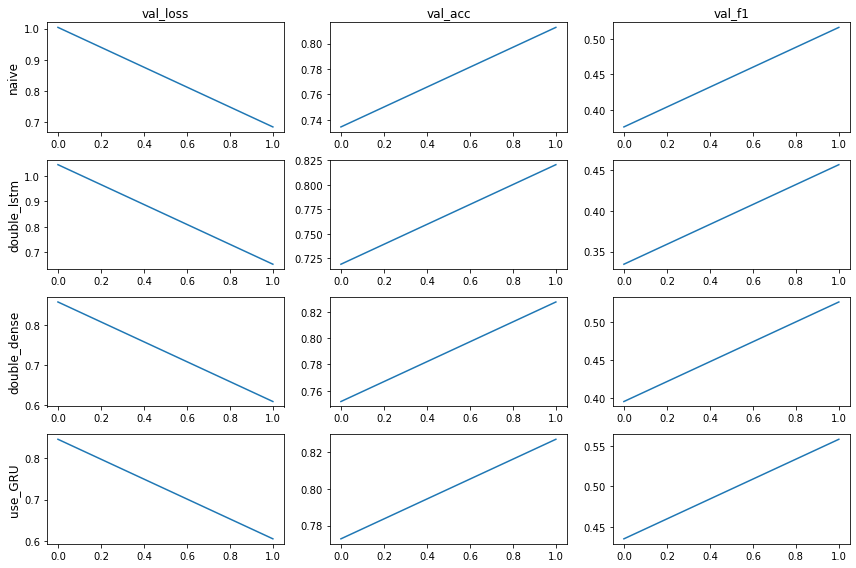

In [44]:
import matplotlib.pyplot as plt

cols = ['val_loss','val_acc','val_f1']
rows = [row for row in models_info.keys()]

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(12, 8))

for ax, col in zip(axes[0], cols):
    ax.set_title(col)

for ax, row in zip(axes[:,0], rows):
    ax.set_ylabel(row, size='large')

keys = list(models_info.keys())

for i in range(4):
  for j in range(3):
      axes[i,j].plot(models_info[keys[i]][cols[j]])

fig.tight_layout()
plt.show();

As we can see from the above results, the performances of the different architectures are comparable in terms of accuracy and F1 score. In particular, the naive one reaches an F1 score between 0.72 and 0.74, with an accuracy of nearly the 90%, which is already a good outcome. Then, adding a second LSTM layer or a double dense layer doesn't seem to really improve the performances, whereas substitute the LSTM with the GRU looks like a great choice, as in that case the model performs better with respect to the others. In the end, the best F1 score achieved on the validation set is around 0.74, with an accuracy of 91%. A batch size of 16 allows also all the architectures to reach the best results in few epochs and this also prevent overfitting.

Now that we have trained all our models, we can pick the two best ones according to the f1 score over the validation set and store them in the dictionary : `two_best_models`.\
We will later use this dictionary in order to further evaluate those models on the Test Set.

In [47]:
ordered_models = dict(sorted(models_info.items(), key=lambda item: item[1]['best_f1'], reverse=True))    #order the models in models_info based on their f1_score 

two_best_models = OrderedDict()      #store in a dictionary the two best models 

for n,(k,v) in enumerate(ordered_models.items()):
    two_best_models[k] = v
    if n==1 : break            #take only the best two 

best_model_name = next(iter(two_best_models))    #we need the very best model to evaluate its errors 
best_model_info = two_best_models[best_model_name]

best_f1, pred, targ = best_model_info['best_f1'],best_model_info['tot_pred'],best_model_info['tot_targ']

print('The single best model is',best_model_name,'with an f1-score of',round(best_f1,2))

The single best model is use_GRU with an f1-score of 0.56


We can already see that while we get an high accuracy we also obtain a relatively low f1-score. This could indicate underfitting on an unbalanced dataset. In particular since the accuracy on the train set was very high, we are probably overfitting on very frequent classes while being incapable of correctly predicting classes that be barely see in the data. 

### 9. Error analysis on Validation Set

Before evaluating the best performing models on the test set, we can perform a simple error analysis about the results of the validation set, in order to understand the errors and think about possible improvements.\
In particular, we have written the following functions to help us visualize and reason upon the errors of our model:
- `build_classification_report`: create classification report showing the precision, recall, f1-score and support for each tag and the final accuracy.
- `build_confusion_matrix`: create a confusion matrix.
- `build_errors_dictionary`: create a dictionary which associates to each tag a list of the tags which is mistaken for (i.e. the ones which our models predict instead of the true label) and the total number of times it happens for each mistaken tag in the validation set.
- `get_tag_distribution`: show the number of occurrences of each tag in the training set.

In [50]:
 
def build_classification_report(targ,pred,unique_tags):
    """
        Generate classification report 
    """
    report = classification_report(targ,pred,zero_division=0,output_dict=False,target_names=unique_tags)
    print(report)


def build_confusion_matrix(targ,pred,unique_tags):
    """
        Build confusion matrix and returns it as a dataframe
    """
    
    cf_matrix = confusion_matrix(targ, pred)
    df_cm = pd.DataFrame(cf_matrix, index = unique_tags, columns = unique_tags)  #put the confusion matrix in a pandas dataframe 

    #plot the confusion matrix as heatmap 
    plt.figure(figsize = (40,32))
    sn.heatmap(df_cm, annot=True, cmap="Blues", linewidths= 0.05, linecolor='white')

    return df_cm

def build_errors_dictionary(df_cm):
    """
        Create a dictionary which contains, for each true tag a list of wrong predicted tags and the number of wrong predictions
    """

    errors = {}
    for true_tag,row in df_cm.iterrows():    #loop on the rows of the dataframe 

        tag_errors = []
        for pred_tag, occurrences in row.iteritems() :     #loop on each column of that specific row 
            if not pred_tag==true_tag and occurrences!=0 : 
                tag_errors.append((pred_tag,occurrences))
        
        tag_errors.sort(key = itemgetter(1),reverse=True)   #sort it so that the tag that is more mistaken for the correct one is the first one to appear on the left 

        if tag_errors:     
            errors[true_tag] = tag_errors     #put it in the dict only if there are actually errors 

    errors = dict(sorted(errors.items(), key = lambda item : item[1][0][1],reverse=True))    #sort the dictionary in order to have the more wrongly classified tags on top 

    #pretty print 
    print('true_TAG --> (pred_TAG, n_times)\n')
    for k,v in errors.items():
        print(k,'-->',*v)

def get_tag_distribution():
    """
        Count number of occurrences of each TAG in the train set 
    """
    tag_frequency = {}
    df_temp = token_dataset[token_dataset['split'] == 'train']
    for _ ,row in df_temp.iterrows():
        for key in row['tags_token']:
            tag_frequency[int2tag[key]] = tag_frequency.get(int2tag[key],0) + 1

    return dict(sorted(tag_frequency.items(), key=lambda item: item[1], reverse = True))

def plot_tag_occur(occ: Dict):
    """
        Creates and plots an image showing the distribution of each unique tag inside the dataset
    """
    fig,ax = plt.subplots()
    ax.set_ylabel('num occurrences in train dataset')
    ax.set_xticks(range(len(occ.keys())))
    ax.bar(occ.keys(), occ.values())

    plt.title("Tags distribution in train dataset")
    fig.set_figwidth(25)
    fig.set_figheight(10)

In [51]:
tags = [int2tag[i] for i in set(targ.tolist() + pred.tolist())]                           #tags as string instead of indexes, for every unique tag in either pred or tag 
print('the number of unique tags in either the predictions or targets is: ',len(tags))

the number of unique tags in either the predictions or targets is:  35


It can be seen how the number of unique tags (true + predicted) is greater than 35 (number of unique tags not counting punctuation in the validation set). This is justified by the fact that the model wrongly predict as punctuation some words which aren't.

Let's see the classification report.

In [52]:
build_classification_report(targ,pred,tags)

              precision    recall  f1-score   support

         NNP       0.75      0.96      0.84      2704
          CC       0.97      0.84      0.90       758
         WP$       0.00      0.00      0.00         4
         VBZ       0.96      0.88      0.91       712
        PRP$       0.97      0.94      0.95       258
         PDT       0.00      0.00      0.00        14
         VBP       0.82      0.67      0.73       460
         JJS       1.00      0.10      0.19        58
          CD       0.92      0.88      0.90      1249
          VB       0.84      0.85      0.85       956
          LS       0.00      0.00      0.00         3
         RBR       0.32      0.66      0.43        35
         WDT       0.75      0.80      0.78       157
         JJR       0.85      0.13      0.23       165
         WRB       1.00      0.03      0.06        62
         NNS       0.84      0.78      0.81      2102
          JJ       0.65      0.65      0.65      1924
          IN       0.91    

The classification report is great to understand what is happening in our classification task.\
For start, it is evident that the overall f1-score is kept low by some specific classes.

By looking at the plot, we can see two bad behaviours:
- Some tags have high precision but low recall, so we predict them well but we also produce a lot of false positives.
- Other tags instead have both low precision and low recall so we are completely incapable of correctly predict them.

By making a comparison between these two types of tags, it can be seen how both have a low support, so there are not many of them in the train dataframe.
\
\
For this reason, we have implemented the function `compute_class_weights` which add weights to the cross entropy loss. It implements the homonymous one of `sklearn` which give more weight to the prediction errors of class underrepresented in the train dataframe, and less to the ones overrepressented. 
\
\
We then tried using the weighted loss as implemented and although it does what it is supposed to, effectively reducing prediction errors for the less represented classes, this also result in an increase in prediction errors among the more represented classes, unfortunately offsetting the positive effects. This is a clear sign that implementing a weighted loss could be beneficial, but aslo that the weights we are using are not the optimal ones. Therefore, we decided not to use the function during the training of the models.
\
\
A possible improvement that would certainly lead to better results would be to determine weights for each class not only based on their frequency of occurence in the train data but also based on how many different words are labeled with that tag. This is because even if a tag class appears several time in the dataset, if many different words are have its label, its weight should not be decreased for the loss computation.  

Now let's plot the confusion matrix.

In [ ]:
df_cm = build_confusion_matrix(targ, pred, tags)

The confusion matrix is useful to understand which tags we get wrong the most and what kind of errors we make.\
In order to have an even more insightful view of the errors we can use the `build_errors_dictionary` function that we have previously defined.

In [ ]:
build_errors_dictionary(df_cm)

We can set a threshold of nearly 70 recurrent fail predictions, and by looking at the results above these are the ones most relevant:
- `NN-JJ`: prediction of nouns as adjectives (mostly because there are a lot of examples of `NN` but few of `JJ`) and viceversa.
- `NN-NNP`: prediction of singular nouns as singular proper nouns (understandable, since they are very similar).
- `JJ-NNP`: prediction of adjectives as singular proper nouns (because of a lot of examples of `NNP` but few of `JJ`) and viceversa.
- `NNPS-NNP`: prediction of plural proper nouns as singular proper nouns (because of few examples of `NNPS` but a lot of `NNP`).
- `NNS-NN`: prediction of plural nouns as singular nouns (because of a lot of examples of `NN` but few of `NNS`) and viceversa.

On the other hand, it's important to take a look also to wrong predictions which occur rarely, because the cause is often that they are present only in few sequences, such as:
- `LS-CD`: few times wrong prediction of cardinal numbers as list item marker (because of few examples of `LS` but a lot of `CD`).
- `FW`: fail in predicting foreign words (because of few examples).
- `UH`: fail in predicting interjections (because of few examples).

To understand which tags are the most frequent within the train set and which are less frequent, we can plot their distribution in the dataset.

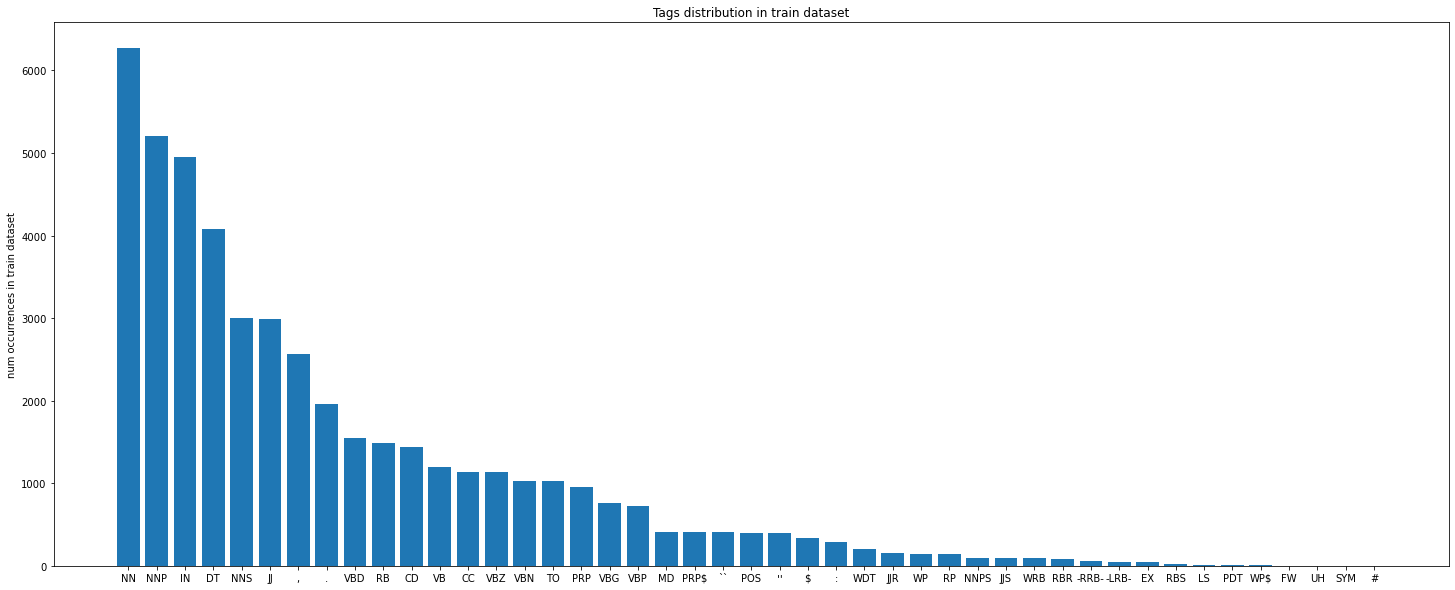

In [53]:
tag_dis = get_tag_distribution()

plot_tag_occur(tag_dis)

This plot reconfirms what has been previously stated, so that there are classes highly represented and others with almost zero examples. Thus the dataset is highly unbalanced. Is now clear that the main errors will be made between similar classes but with a big difference in representation in the dataset and on classes not very represented at all.

### 10. Test of two best models

After evaluating the mistakes made on the validation set and improving the models accordingly, it is now time to evaluate the two best models using the sentences of the Test Set.

In [ ]:
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX, weight = compute_class_weights() if USE_CLASS_WEIGHTS else None)

test_pred, test_targ = None, None        #store the predicted labels and the true labels for the best model on test set 
 
for model_name,model_info in two_best_models.items():
    model = model_info['model']
    loss, acc, f1, tot_pred, tot_targ = eval_loop(model,test_dataloader,criterion,PAD_IDX)

    print(model_name,f': Test Loss: {loss:.3f} | Test Acc: {acc*100:.2f}% | Test F1: {f1:.2f}')

    if model_name == best_model_name:
        test_pred, test_targ = tot_pred, tot_targ

tags = [int2tag[i] for i in set(test_targ.tolist() + test_pred.tolist())]                           #tags as string instead of indexes, for every unique tag in pred or tag 
print('\nthe number of unique tags in either the predictions or targets is: ',len(tags))

In [ ]:
build_classification_report(test_targ,test_pred,tags)

In [ ]:
df_cm = build_confusion_matrix(test_targ, test_pred, tags)

In [ ]:
build_errors_dictionary(df_cm)